In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

%load_ext autoreload
%autoreload 2


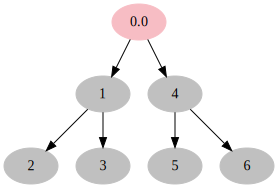

In [2]:
from distributions import Categorical
from mouselab import MouselabEnv
env = MouselabEnv(height=2, reward=Categorical([-1, 1]), cost=0.1)
env.render()

# Define features

In [4]:
# from toolz.curried import *
# # max_paths = len(click_features(env.init, 1)) / 3
# max_paths = 2

# @curry
# def path_features(state, path):
#     val = env.node_value_to(path[-1], state=state)
#     return [val.mean, val.var, val.mean * val.var]

# def click_features(state, click):
#     x = np.zeros(6)
#     pfs = sorted(map(path_features(state), env.all_paths(start=click)))
#     while len(pfs) < max_paths:
#         pfs.append([0, 0, 0])
#     return np.concatenate(pfs)

# Regress to optimal policy

In [15]:
from exact import solve, hash_tree
Q, V, pi, info = solve(env)
V(env.init)

0.8999999999999999

In [5]:
from toolz import memoize
   
def regression_data():
    """Returns features and Q* for all(*) state-action pairs in an env.
    
    (*) the state space is reduced by treating symmetric states as one.
    """
#     Q, V, pi, info = solve(env)
    data = []
    @memoize(key=lambda args, kwargs: hash_tree(env, args[0]))
    def rec(s):
        for a in env.actions(s):
            if a == env.term_action: continue
            for p, s1, r in env.results(s, a):
                data.append({
                    'features': click_features(s, a),
                    'state': s,
                    'action': a,
                    'q_star': Q(s, a)
                })
                rec(s1)
    rec(env.init)
    return pd.DataFrame(data)

df = regression_data()

In [6]:
from sklearn.linear_model import LinearRegression
X = np.stack(df.features)
model = LinearRegression().fit(X, df.q_star)

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


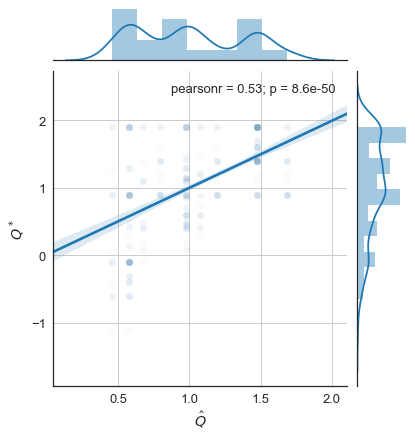

In [7]:
sns.jointplot(model.predict(X), df.q_star, kind='reg',
              joint_kws=dict(scatter_kws=dict(alpha=0.01)))
plt.grid()
plt.ylabel(r'$Q^*$')
plt.xlabel(r'$\hat{Q}$')

# Softmax-Q policy

In [8]:
from agents import Agent
from evaluation import get_util
from human_model import *
from model_utils import *
from policies import RandomPolicy, FixedPlanPolicy, LiederPolicy

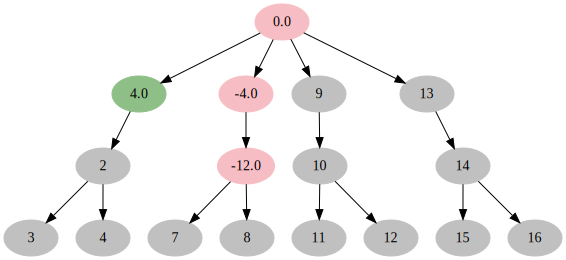

In [112]:
env = make_env(1.25)
env.reset()
for a in [1, 5, 6,]:
    env.step(a)
env.render()

In [115]:
print(action_features(env, env._state, 9).round(3))
print(action_features(env, env._state, 11).round(3))

[  0.      1.      0.     17.172   0.      0.     17.172   0.   ]
[  0.      1.      0.     17.172   0.      0.      0.      0.   ]


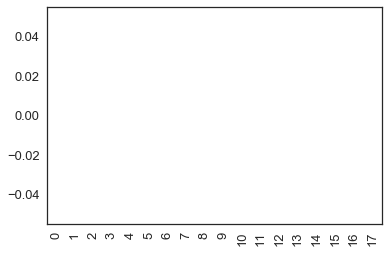

In [101]:
from human_model import *
agent = Agent()
theta = np.ones(8)
pol = HumanPolicy(theta=theta, temp=0)
agent.register(env)
agent.register(pol)
pd.Series(pol.action_distribution(env._state)).plot.bar()

In [409]:
from model_utils import make_env

def get_human(cost):
    env = make_env(cost)
    return HumanPolicy.optimize([env] * 200, n_calls=50)

COSTS = np.logspace(-10, 0, 11, base=2)
from joblib import delayed, Parallel
results = Parallel(11)(delayed(get_human)(cost) for cost in COSTS)
human = dict(zip(COSTS, results))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10a3bddb0, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10a3bddb0, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from model_utils import make_env\n\ndef get_human(... cost in COSTS)\nhuman = dict(zip(COSTS, results))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 17, 3, 1, 45, 377702, tzinfo=tzutc()), 'msg_id': '4C75A73C41C24AC99EF90E46CE9A11F8', 'msg_type': 'execute_request', 'session': '03F0A0B32FC6442CB5AFDE8F42FC342D', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4C75A73C41C24AC99EF90E46CE9A11F8', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'03F0A0B32FC6442CB5AFDE8F42FC342D']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from model_utils import make_env\n\ndef get_human(... cost in COSTS)\nhuman = dict(zip(COSTS, results))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 17, 3, 1, 45, 377702, tzinfo=tzutc()), 'msg_id': '4C75A73C41C24AC99EF90E46CE9A11F8', 'msg_type': 'execute_request', 'session': '03F0A0B32FC6442CB5AFDE8F42FC342D', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4C75A73C41C24AC99EF90E46CE9A11F8', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'03F0A0B32FC6442CB5AFDE8F42FC342D'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from model_utils import make_env\n\ndef get_human(... cost in COSTS)\nhuman = dict(zip(COSTS, results))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 17, 3, 1, 45, 377702, tzinfo=tzutc()), 'msg_id': '4C75A73C41C24AC99EF90E46CE9A11F8', 'msg_type': 'execute_request', 'session': '03F0A0B32FC6442CB5AFDE8F42FC342D', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4C75A73C41C24AC99EF90E46CE9A11F8', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from model_utils import make_env\n\ndef get_human(... cost in COSTS)\nhuman = dict(zip(COSTS, results))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from model_utils import make_env\n\ndef get_human(... cost in COSTS)\nhuman = dict(zip(COSTS, results))'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from model_utils import make_env\n\ndef get_human(... cost in COSTS)\nhuman = dict(zip(COSTS, results))',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from model_utils import make_env\n\ndef get_human(... cost in COSTS)\nhuman = dict(zip(COSTS, results))',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from model_utils import make_env\n\ndef get_human(... cost in COSTS)\nhuman = dict(zip(COSTS, results))', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.FunctionDef object>, <_ast.Assign object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-409-8cf55e3f0a79>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 127965e10, execution_..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x11b863540, file "<ipython-input-409-8cf55e3f0a79>", line 9>
        result = <ExecutionResult object at 127965e10, execution_..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x11b863540, file "<ipython-input-409-8cf55e3f0a79>", line 9>, result=<ExecutionResult object at 127965e10, execution_..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x11b863540, file "<ipython-input-409-8cf55e3f0a79>", line 9>
        self.user_global_ns = {'Agent': <class 'agents.Agent'>, 'COSTS': array([  9.766e-04,   1.953e-03,   3.906e-03,   ....250e-01,   2.500e-01,   5.000e-01,   1.000e+00]), 'Categorical': <class 'distributions.Categorical'>, 'Continuous': <class 'pymc3.distributions.distribution.Continuous'>, 'Counter': <class 'collections.Counter'>, 'ENV': <mouselab.MouselabEnv object>, 'FixedPlanPolicy': <class 'policies.FixedPlanPolicy'>, 'HumanModel': <class 'human_model.HumanModel'>, 'HumanPolicy': <class 'human_model.HumanPolicy'>, 'In': ['', "get_ipython().magic('matplotlib inline')\n\nimport... autoreload')\nget_ipython().magic('autoreload 2')", 'from distributions import Categorical\nfrom mouse...ward=Categorical([-1, 1]), cost=0.1)\nenv.render()', 'from agents import Agent\nfrom evaluation import ...mport RandomPolicy, FixedPlanPolicy, LiederPolicy', 'np.r_[1, 0, [0] * 3 * 2]', 'from human_model import action_features\n\naction_features(env, env.init, 1)[1] ** 0.5', 'from human_model import action_features\n\naction_features(env, env.init, 1)[1] ** 0.5', 'from human_model import action_features\n\naction_features(env, env.init, 1)[1] ** 0.5', 'from human_model import action_features\n\naction_features(env, env.init, 1)', 'def zero_pad(x, size):\n    return np._r[x, np.zeros(size - len(x))]\n\nzero_pad([1,2], 5)', 'def zero_pad(x, size):\n    return np.r_[x, np.zeros(size - len(x))]\n\nzero_pad([1,2], 5)', 'def zero_pad(x, size):\n    return np.concataenate[x, np.zeros(size - len(x))]\n\nzero_pad([1,2], 5)', 'def zero_pad(x, size):\n    return np.concatenate[x, np.zeros(size - len(x))]\n\nzero_pad([1,2], 5)', 'def zero_pad(x, size):\n    return np.concatenate(x, np.zeros(size - len(x)))\n\nzero_pad([1,2], 5)', 'def zero_pad(x, size):\n    return np.r_[x, np.zeros(size - len(x))]\n\nzero_pad([1,2], 5)', 'np.r_[[1,2], 2, 3, [4,5]]', 'np.r_[[1,2], 2, 3, [[4,5]]]', 'np.r_[[1,2], 2, 3, [[4,5], [4]]]', 'np.r_[[1,2], 2, 3, [[4,5], 4]]', 'from human_model import action_features\n\naction_features(env, env.init, 1)', ...], ...}
        self.user_ns = {'Agent': <class 'agents.Agent'>, 'COSTS': array([  9.766e-04,   1.953e-03,   3.906e-03,   ....250e-01,   2.500e-01,   5.000e-01,   1.000e+00]), 'Categorical': <class 'distributions.Categorical'>, 'Continuous': <class 'pymc3.distributions.distribution.Continuous'>, 'Counter': <class 'collections.Counter'>, 'ENV': <mouselab.MouselabEnv object>, 'FixedPlanPolicy': <class 'policies.FixedPlanPolicy'>, 'HumanModel': <class 'human_model.HumanModel'>, 'HumanPolicy': <class 'human_model.HumanPolicy'>, 'In': ['', "get_ipython().magic('matplotlib inline')\n\nimport... autoreload')\nget_ipython().magic('autoreload 2')", 'from distributions import Categorical\nfrom mouse...ward=Categorical([-1, 1]), cost=0.1)\nenv.render()', 'from agents import Agent\nfrom evaluation import ...mport RandomPolicy, FixedPlanPolicy, LiederPolicy', 'np.r_[1, 0, [0] * 3 * 2]', 'from human_model import action_features\n\naction_features(env, env.init, 1)[1] ** 0.5', 'from human_model import action_features\n\naction_features(env, env.init, 1)[1] ** 0.5', 'from human_model import action_features\n\naction_features(env, env.init, 1)[1] ** 0.5', 'from human_model import action_features\n\naction_features(env, env.init, 1)', 'def zero_pad(x, size):\n    return np._r[x, np.zeros(size - len(x))]\n\nzero_pad([1,2], 5)', 'def zero_pad(x, size):\n    return np.r_[x, np.zeros(size - len(x))]\n\nzero_pad([1,2], 5)', 'def zero_pad(x, size):\n    return np.concataenate[x, np.zeros(size - len(x))]\n\nzero_pad([1,2], 5)', 'def zero_pad(x, size):\n    return np.concatenate[x, np.zeros(size - len(x))]\n\nzero_pad([1,2], 5)', 'def zero_pad(x, size):\n    return np.concatenate(x, np.zeros(size - len(x)))\n\nzero_pad([1,2], 5)', 'def zero_pad(x, size):\n    return np.r_[x, np.zeros(size - len(x))]\n\nzero_pad([1,2], 5)', 'np.r_[[1,2], 2, 3, [4,5]]', 'np.r_[[1,2], 2, 3, [[4,5]]]', 'np.r_[[1,2], 2, 3, [[4,5], [4]]]', 'np.r_[[1,2], 2, 3, [[4,5], 4]]', 'from human_model import action_features\n\naction_features(env, env.init, 1)', ...], ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/fred/Projects/mcrl/python/<ipython-input-409-8cf55e3f0a79> in <module>()
      4     env = make_env(cost)
      5     return HumanPolicy.optimize([env] * 200, n_calls=50)
      6 
      7 COSTS = np.logspace(-10, 0, 11, base=2)
      8 from joblib import delayed, Parallel
----> 9 results = Parallel(11)(delayed(get_human)(cost) for cost in COSTS)
     10 human = dict(zip(COSTS, results))

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=11), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=11)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Dec 16 19:07:23 2017
PID: 29275               Python 3.6.3: /usr/local/lib/miniconda3/bin/python
...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function get_human>, (0.0009765625,), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function get_human>
        args = (0.0009765625,)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/fred/Projects/mcrl/python/<ipython-input-409-8cf55e3f0a79> in get_human(cost=0.0009765625)
      1 from model_utils import make_env
      2 
      3 def get_human(cost):
      4     env = make_env(cost)
----> 5     return HumanPolicy.optimize([env] * 200, n_calls=50)
      6 
      7 COSTS = np.logspace(-10, 0, 11, base=2)
      8 from joblib import delayed, Parallel
      9 results = Parallel(11)(delayed(get_human)(cost) for cost in COSTS)
     10 human = dict(zip(COSTS, results))

...........................................................................
/Users/fred/Projects/mcrl/python/human_model.py in optimize(cls=<class 'human_model.HumanPolicy'>, envs=[<mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, <mouselab.MouselabEnv object>, ...], n_jobs=None, verbose=False, **kwargs={'n_calls': 50})
    107             (1., 1.),                       # term reward
    108             (-5., 5.),                      # is click
    109             *([(-1., 1.)] * max_paths * 3)  # node_features
    110         ]
    111         with Timer() as t:
--> 112             result = gp_minimize(objective, bounds, **kwargs)
        result = undefined
        objective = <function HumanPolicy.optimize.<locals>.objective>
        bounds = [(1.0, 1.0), (-5.0, 5.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]
        kwargs = {'n_calls': 50}
    113         theta = np.array(result.x)
    114         util = -result.fun
    115 
    116         print('BO:', theta.round(3), '->', round(util, 3),

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/skopt/optimizer/gp.py in gp_minimize(func=<function HumanPolicy.optimize.<locals>.objective>, dimensions=[(1.0, 1.0), (-5.0, 5.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)], base_estimator=GaussianProcessRegressor(alpha=0.0, copy_X_train...state=<mtrand.RandomState object at 0x10c6e9750>), n_calls=50, n_random_starts=10, acq_func='gp_hedge', acq_optimizer='auto', x0=None, y0=None, random_state=None, verbose=False, callback=None, n_points=10000, n_restarts_optimizer=5, xi=0.01, kappa=1.96, noise='gaussian', n_jobs=1)
    214         acq_func=acq_func,
    215         xi=xi, kappa=kappa, acq_optimizer=acq_optimizer, n_calls=n_calls,
    216         n_points=n_points, n_random_starts=n_random_starts,
    217         n_restarts_optimizer=n_restarts_optimizer,
    218         x0=x0, y0=y0, random_state=random_state, verbose=verbose,
--> 219         callback=callback, n_jobs=n_jobs)
        callback = None
        n_jobs = 1

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/skopt/optimizer/base.py in base_minimize(func=<function HumanPolicy.optimize.<locals>.objective>, dimensions=Space([Real(low=1.0, high=1.0, prior=uniform, tr..., high=1.0, prior=uniform, transform=normalize)]), base_estimator=GaussianProcessRegressor(alpha=0.0, copy_X_train...state=<mtrand.RandomState object at 0x10c6e9750>), n_calls=50, n_random_starts=10, acq_func='gp_hedge', acq_optimizer='auto', x0=[], y0=None, random_state=None, verbose=False, callback=None, n_points=10000, n_restarts_optimizer=5, xi=0.01, kappa=1.96, n_jobs=1)
    246         next_x = optimizer.ask()
    247 
    248         # no need to fit a model on the last iteration
    249         fit_model = n < n_calls - 1
    250         next_y = func(next_x)
--> 251         result = optimizer.tell(next_x, next_y, fit=fit_model)
        result =           fun: -12.396220703125
    func_vals: a...6583, 0.86976321729280737, -0.75945384848262298]]
        next_x = [1.0, -0.062028368270912182, 0.53579300941556984, -0.099303487764727416, -0.15517094872488379, 0.98527459063826583, 0.86976321729280737, -0.75945384848262298]
        next_y = -6.9779394531249999
        fit_model = True
    252         result.specs = specs
    253 
    254         if eval_callbacks(callbacks, result):
    255             break

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py in tell(self=<skopt.optimizer.optimizer.Optimizer object>, x=[1.0, -0.062028368270912182, 0.53579300941556984, -0.099303487764727416, -0.15517094872488379, 0.98527459063826583, 0.86976321729280737, -0.75945384848262298], y=-6.9779394531249999, fit=True)
    445             transformed_bounds = np.array(self.space.transformed_bounds)
    446             est = clone(self.base_estimator_)
    447 
    448             with warnings.catch_warnings():
    449                 warnings.simplefilter("ignore")
--> 450                 est.fit(self.space.transform(self.Xi), self.yi)
        self.space.transform = <bound method Space.transform of Space([Real(low... high=1.0, prior=uniform, transform=normalize)])>
        self.Xi = [[1.0, -3.069377915168428, -0.44298678786825996, -0.68330442535605207, -0.76442316498407714, 0.22633056371554305, 0.96568521514778638, 0.095960414763776036], [1.0, -0.17072637825399273, -0.81875741445440409, 0.20629518897452037, 0.30218054690515594, 0.94673919203689705, 0.11236559069074925, -0.43016620915294335], [1.0, 0.71734086744728387, -0.33325639224533432, 0.70001923647228215, 0.32555238939302678, 0.74736859595794169, -0.51340373104457415, 0.3871837115575707], [1.0, 2.549093867411254, -0.30598732833185649, 0.68821222084617562, -0.0097126174650619124, -0.62678337576183352, 0.40317429518393477, -0.62773275446301424], [1.0, -2.36820439776164, -0.24225860481935513, -0.37091096730131146, -0.88686916369866431, 0.48386555246323337, 0.38902587687209711, 0.40943967840500717], [1.0, 2.9431960211325414, -0.6618455946893822, -0.61544167829444352, 0.5582924864408334, -0.3656147078463573, -0.95748942681354743, -0.45308705373656], [1.0, 3.9100054800385937, 0.76629153480722678, 0.14702298547058978, -0.86316389053717568, -0.22577510170669157, -0.41337246478695044, 0.41055273439693507], [1.0, -0.79446999596929402, 0.075900539066467543, 0.98306632951734518, -0.36862398852635569, 0.92282265177906697, 0.65135082929688171, -0.97849733420821572], [1.0, -0.33284619777549818, 0.17483520754637749, 0.76651497881429487, 0.98377897464036379, 0.74417393365454254, -0.33474964071670088, 0.7777674453688479], [1.0, -0.062028368270912182, 0.53579300941556984, -0.099303487764727416, -0.15517094872488379, 0.98527459063826583, 0.86976321729280737, -0.75945384848262298]]
        self.yi = [-5.1868231931706532e-16, -8.4173730468749994, -8.0980468749999996, -8.1578808593750001, -5.1868231931706532e-16, -8.1581689453125001, -12.396220703125, -8.5378027343749991, -8.3379345703125001, -6.9779394531249999]
    451 
    452             if hasattr(self, "next_xs_") and self.acq_func == "gp_hedge":
    453                 self.gains_ -= est.predict(np.vstack(self.next_xs_))
    454             self.models.append(est)

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py in fit(self=GaussianProcessRegressor(alpha=0.0, copy_X_train...state=<mtrand.RandomState object at 0x12babda20>), X=array([[   nan,  0.193,  0.279,  0.158,  0.118, ... 0.768,  0.45 ,  0.422,  0.993,  0.935,  0.12 ]]), y=[-5.1868231931706532e-16, -8.4173730468749994, -8.0980468749999996, -8.1578808593750001, -5.1868231931706532e-16, -8.1581689453125001, -12.396220703125, -8.5378027343749991, -8.3379345703125001, -6.9779394531249999])
    190             self.kernel = self.kernel + WhiteKernel()
    191         elif self.noise:
    192             self.kernel = self.kernel + WhiteKernel(
    193                 noise_level=self.noise, noise_level_bounds="fixed"
    194             )
--> 195         super(GaussianProcessRegressor, self).fit(X, y)
        self.fit = <bound method GaussianProcessRegressor.fit of Ga...tate=<mtrand.RandomState object at 0x12babda20>)>
        X = array([[   nan,  0.193,  0.279,  0.158,  0.118, ... 0.768,  0.45 ,  0.422,  0.993,  0.935,  0.12 ]])
        y = [-5.1868231931706532e-16, -8.4173730468749994, -8.0980468749999996, -8.1578808593750001, -5.1868231931706532e-16, -8.1581689453125001, -12.396220703125, -8.5378027343749991, -8.3379345703125001, -6.9779394531249999]
    196 
    197         self.noise_ = None
    198 
    199         if self.noise:

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py in fit(self=GaussianProcessRegressor(alpha=0.0, copy_X_train...state=<mtrand.RandomState object at 0x12babda20>), X=array([[   nan,  0.193,  0.279,  0.158,  0.118, ... 0.768,  0.45 ,  0.422,  0.993,  0.935,  0.12 ]]), y=[-5.1868231931706532e-16, -8.4173730468749994, -8.0980468749999996, -8.1578808593750001, -5.1868231931706532e-16, -8.1581689453125001, -12.396220703125, -8.5378027343749991, -8.3379345703125001, -6.9779394531249999])
    161         else:
    162             self.kernel_ = clone(self.kernel)
    163 
    164         self.rng = check_random_state(self.random_state)
    165 
--> 166         X, y = check_X_y(X, y, multi_output=True, y_numeric=True)
        X = array([[   nan,  0.193,  0.279,  0.158,  0.118, ... 0.768,  0.45 ,  0.422,  0.993,  0.935,  0.12 ]])
        y = [-5.1868231931706532e-16, -8.4173730468749994, -8.0980468749999996, -8.1578808593750001, -5.1868231931706532e-16, -8.1581689453125001, -12.396220703125, -8.5378027343749991, -8.3379345703125001, -6.9779394531249999]
    167 
    168         # Normalize target value
    169         if self.normalize_y:
    170             self.y_train_mean = np.mean(y, axis=0)

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py in check_X_y(X=array([[   nan,  0.193,  0.279,  0.158,  0.118, ... 0.768,  0.45 ,  0.422,  0.993,  0.935,  0.12 ]]), y=[-5.1868231931706532e-16, -8.4173730468749994, -8.0980468749999996, -8.1578808593750001, -5.1868231931706532e-16, -8.1581689453125001, -12.396220703125, -8.5378027343749991, -8.3379345703125001, -6.9779394531249999], accept_sparse=None, dtype='numeric', order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=True, ensure_min_samples=1, ensure_min_features=1, y_numeric=True, warn_on_dtype=False, estimator=None)
    516     y_converted : object
    517         The converted and validated y.
    518     """
    519     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    520                     ensure_2d, allow_nd, ensure_min_samples,
--> 521                     ensure_min_features, warn_on_dtype, estimator)
        ensure_min_features = 1
        warn_on_dtype = False
        estimator = None
    522     if multi_output:
    523         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    524                         dtype=None)
    525     else:

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=array([[   nan,  0.193,  0.279,  0.158,  0.118, ... 0.768,  0.45 ,  0.422,  0.993,  0.935,  0.12 ]]), accept_sparse=None, dtype=None, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    402             array = array.astype(np.float64)
    403         if not allow_nd and array.ndim >= 3:
    404             raise ValueError("Found array with dim %d. %s expected <= 2."
    405                              % (array.ndim, estimator_name))
    406         if force_all_finite:
--> 407             _assert_all_finite(array)
        array = array([[   nan,  0.193,  0.279,  0.158,  0.118, ... 0.768,  0.45 ,  0.422,  0.993,  0.935,  0.12 ]])
    408 
    409     shape_repr = _shape_repr(array.shape)
    410     if ensure_min_samples > 0:
    411         n_samples = _num_samples(array)

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py in _assert_all_finite(X=array([[   nan,  0.193,  0.279,  0.158,  0.118, ... 0.768,  0.45 ,  0.422,  0.993,  0.935,  0.12 ]]))
     53     # everything is finite; fall back to O(n) space np.isfinite to prevent
     54     # false positives from overflow in sum method.
     55     if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
     56             and not np.isfinite(X).all()):
     57         raise ValueError("Input contains NaN, infinity"
---> 58                          " or a value too large for %r." % X.dtype)
        X.dtype = dtype('float64')
     59 
     60 
     61 def assert_all_finite(X):
     62     """Throw a ValueError if X contains NaN or infinity.

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
___________________________________________________________________________

In [34]:
# from exact import solve
# def optimal_util(cost):
#     env = MouselabEnv(height=2, cost=cost, reward=Categorical([-1, 1]))
#     Q, V, pi, info = solve(env)
#     return V(env.init)

# dd = pd.DataFrame({
#         'cost': COSTS,
#         'agent': 'optimal'
#     })
# dd['util'] = dd.cost.apply(optimal_util)
# df = pd.concat([df_, dd])

In [11]:
from human_model import HumanPolicy
from policies import FixedPlanPolicy, LiederPolicy

def data(cost):
    env = MouselabEnv(height=2, cost=cost, reward=Categorical([-1, 1]))
    agent = Agent()
    agent.register(env)
    policies = {
        'human': human[cost],
        'random': RandomPolicy(),
        'full-observation': FixedPlanPolicy(range(1, env.term_action+1)),
        'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
    }
    df = evaluate_many(policies, [env] * 2000)
    df['']
    df['cost'] = cost

jobs = (delayed(data)(c) for c in COSTS)
df = pd.concat(Parallel(11)(jobs))

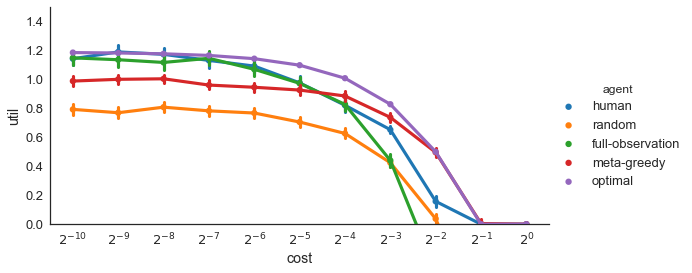

In [53]:
g = sns.factorplot('cost', 'util', hue='agent', data=df, markers='.',
                aspect=2)
plt.ylim(0, 1.5)
g.set_xticklabels([f'$2^{{{i}}}$' for i in range(-10, 1)])

# Simulate experiment

In [104]:
from analysis_utils import *
df, pdf = load('1.8')
COSTS = pdf.info_cost.unique()

def load_envs():
    envs = {}
    for cost in pdf.info_cost.unique():
        with open(f'../experiments/exp1/static/json/rewards_{cost:.2f}.json') as f:
            d = json.load(f)
            for trial in concatv(d['train'], d['test']):
                envs[trial['trial_id']] = make_env(cost, ground_truth=trial['stateRewards'])
    return envs
    
envs = load_envs()

In [106]:
cost = 1.25
pol = HumanPolicy.optimize([make_env(cost)] * 50, n_calls=30)
# optimized = {c: HumanPolicy.optimize([make_env(c)] * 200, n_calls=100) for c in COSTS}

BO: [ 1.     5.     1.     0.839  1.     0.522  1.     1.   ] -> 12.76 in 64 sec


In [120]:
label = Labeler()
def simulate(policy, envs):
    agent = Agent()
    agent.register(ENV)
    agent.register(policy)
    for trial_id, env in envs.items():
        agent.register(env)
        trace = agent.run_episode()
        for s, a in zip(trace['states'], trace['actions']):
            yield {'pid': -1, 'cost': abs(env.cost), 'trial_id': trial_id,
                   'state': label(s), 'action': a}
            

sdf = pd.DataFrame(simulate(pol, envs))
data = sdf.query('cost == 1.25')

# Fit human data

In [459]:
from analysis_utils import load
from model_utils import *
from toolz import *
from human_model import action_features

label = Labeler()
def expand():
    for i, row in df.iterrows():
        for s, a in zip(row.states, concatv(row.clicks, [ENV.term_action])):
            yield {'pid': row.pidx, 'cost': row.info_cost, 'pr_type': row.pr_type,
                   'state': label(parse_state(s)), 'action': a, 'trial_id': row.trial_id}

data = pd.DataFrame(expand())
data.head()

,action,cost,pid,pr_type,state,trial_id
0,1,1.25,0,none,0,8969
1,17,1.25,0,none,1,8969
2,5,1.25,0,none,0,9359
3,9,1.25,0,none,2,9359
4,1,1.25,0,none,3,9359


Likelihood:
$$p(D \mid \theta) = \prod_i^N p(a_i \mid s_i; \theta)$$

Softmax Q policy:
$$p(a \mid s; \theta) = \frac{\exp \{ Q(s, a; \theta) \} }{ \sum_{a'} \exp \{ Q(s, a'; \theta) \} }$$

Linear regression Q:
$$Q(s, a; \theta) = \theta^\top \phi(s, a)$$

Before performing inference, we precompute the features, storing them in a 3d tensor.
`phi[s, a, f]` will give the value $\phi(s, a)_f$


In [121]:
phi = np.array([[action_features(env, s, a) for a in range(env.term_action + 1)]
                 for s in label._xs])


In [138]:
def logp(theta, temp=1):
    Q = np.dot(phi[data.state.as_matrix()], theta)
    idx = np.arange(len(data))
    eq = np.exp(Q / temp)
    chosen = eq[idx, data.action.as_matrix()]
    return np.log(chosen / (eq.sum(1) + 1e-10)).sum()
    
# print(logp(np.r_[1, trace['theta'].mean(0)]))
print(logp(pol.theta))

-137.603188169


In [139]:
import pymc3 as pm
import theano.tensor as tt

n_pid = data.pid.max() + 1
n_feature = len(phi[0,0])
idx = np.arange(len(data))

with pm.Model() as model:
    
    theta = pm.Normal('theta', 0, 5, shape=n_feature-1)
    temp = 1
    Q = tt.dot(phi[data.state.as_matrix()], tt.concatenate([[1], theta]))
    eq = tt.exp(Q / temp)
    chosen = eq[idx, data.action.as_matrix()]
    pm.Potential('logp', np.log(chosen / (eq.sum(1) + 1e-10)).sum())
    
    trace = pm.sample()
    
    

 99%|█████████▉| 994/1000 [00:17<00:00, 59.72it/s]/usr/local/lib/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.878641676481, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/usr/local/lib/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 43 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:17<00:00, 57.56it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a3b4cf8>, <matplotlib.axes._subplots.AxesSubplot object at 0x1190133c8>]], dtype=object)

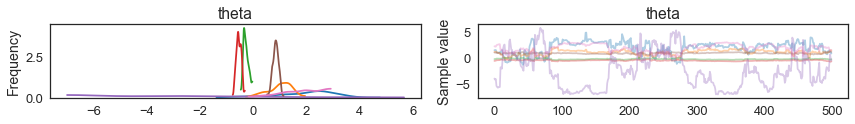

In [83]:
pm.traceplot(trace)

In [65]:
trace.varnames

['theta']

In [87]:
trace['theta'].std(0)

array([ 1.166,  0.452,  0.098,  0.09 ,  3.28 ,  0.109,  0.764])

In [88]:
pol.temp

0

In [86]:
ipol = HumanPolicnp.r_[1, trace['theta'].mean(0)]

array([ 1.   ,  1.893,  0.995, -0.267, -0.54 , -2.57 ,  0.844,  1.777])